# LAB 2

**Students**:
- **Hamza GHARBI**
- **Ghassen BETTAIEB**

In [1]:
import numpy as np
from scipy.special import lambertw
import copy
import matplotlib.pyplot as plt
import copy
%matplotlib inline

## Generation of Synthetic data

### Signal : discretization

In [2]:
#load signal
signal = np.loadtxt("signal.txt").flatten()

In [3]:
N = len(signal)

In [4]:
T_min = 1
T_max = 1000
T = []
for i in range(1,N+1):
    T.append(T_min*np.exp(-(i-1)*np.log(T_min/T_max)/(N-1)))

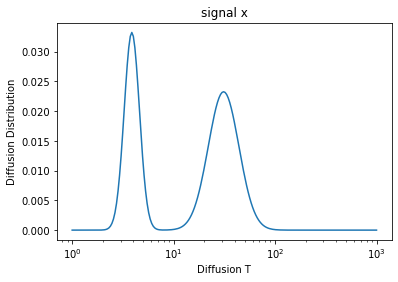

In [5]:
plt.xscale('log')
plt.plot(T,signal)
plt.title("signal x")
plt.xlabel("Diffusion T")
plt.ylabel("Diffusion Distribution")
plt.show()

### Simulate noisy data

The noisy data to be simulated is: 
$$
y = K \bar x + w
$$
With : $X \sim \mathcal{N}(0,\,\sigma^{2}Id)$ and $\sigma = 0.01(K\bar x)^{1}$ 

In [6]:
#create t using regular sampling strategy
M = 50
t_min = 0
t_max = 1.5
t = []
for i in range(1,M+1):
    t.append(t_min+(i-1)/(M-1)*(t_max-t_min))

In [8]:
#construct the discretization Matrix K
K = np.zeros((M,N))
for m in range(M):
    for n in range(N):
        K[m,n] = np.exp(-T[n]*t[m])

In [9]:
#simulate the noisy data
z = K@signal
z1 = z[0]
sigma = 0.01*z1
W = np.random.multivariate_normal(mean = [0]*M, cov = (sigma**2)*np.eye(M))

y = K@signal + W

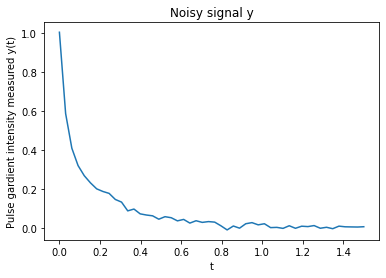

In [10]:
plt.plot(t,y)
plt.title("Noisy signal y")
plt.xlabel("t")
plt.ylabel("Pulse gardient intensity measured y(t)")
plt.show()

To find the optimal $\hat x \in R^{n}$ we need to solve the general optimization problem: 
$$
\hat{x} = \underset{x \in R^{N}}  {\mathrm{argmin}} \; \frac{1}{2} \left\|Kx -y\right\|^{2} + \beta g(x)
$$
Where: <br>
- $K \in R^{NxN}$ is the descretization matrix. <br>
- $\beta$ is the regularization parameter
- $g$ is the penalization's function.

In the following part we will try 3 different penalizations approaches: The smoothness prior, the smoothness prior+constraints and the sparsity prior.

## Comparison of regularization strategies

### 1. Smoothness prior

In [11]:
#create matrix D
L = [1] + [0]*(N-2) + [-1]
L_arr = np.array(L)
D = L_arr
for n in range(N):
    L = np.roll(L,1)
    D = np.vstack((D,L))

We define a set of candidate values for $\beta$. For each value of $\beta$ we compute the optimal signal solution $\hat{x}$ and the correspondant error.

In [12]:
betas = [2**i for i in range(-6,3)]
errors = []
for beta in betas:
    x_hat = np.linalg.inv(K.T@K + beta*D.T@D)@K.T@y
    error = np.linalg.norm(x_hat - signal)**2 / np.linalg.norm(signal)**2
    errors.append(error)

The best value of $\beta$ is the one that yields the lowest error value.

In [13]:
#retrieve the best candidate beta value
best_beta = betas[np.argmin(errors)]

#use the best beta value to estimate the signal
x_hat = np.linalg.inv(K.T@K + best_beta*D.T@D)@K.T@y

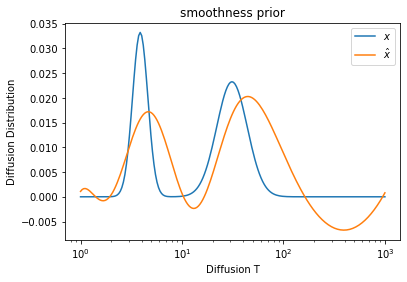

In [14]:
#plot the estimated signal and estimated signal
plt.figure()
plt.xscale('log')
plt.plot(T,signal, label = "$x$")
plt.plot(T,x_hat, label = "$\hat{x}$")



lines = plt.gca().get_lines()
include = [0,1]
legend1 = plt.legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc=1)

plt.title("smoothness prior")
plt.ylabel('Diffusion Distribution')
plt.xlabel('Diffusion T')
plt.show()

### 2. Smoothness prior + constraints

In [27]:
def solver(signal,y, beta):
    #determine nu
    Hess =  K.T@K + beta*D.T@D
    nu = max(np.abs(np.linalg.eigvals(Hess)))
    #initialize x
    x_min = min(signal)
    x_max = max(signal) 
    x = [0.5*(x_min+x_max)]*len(signal)
    x = np.array(x)
    #initialize gamma, delta, lambda
    gamma = 1.999/nu
    delta=2-nu*gamma/2
    lambd = 0.99*delta
        
    #stopping criterions
    error = 1e6
    
    #initialize number of iteration
    iteration = 1
    max_iter=6000
    
    while iteration<max_iter and error> 1e-8:
        y_n = x - gamma*(K.T@K@x - K.T@y + beta*D.T@D@x)
        #compute p_c
        p_c = []
        for i in range(len(x)):
            if y_n[i]<x_min:
                p_c.append(x_min)
            elif y_n[i]>x_max:
                p_c.append(x_max)
            else:
                p_c.append(y_n[i])
        p_c = np.array(p_c)
        
        error = np.linalg.norm(lambd*(p_c - x))**2/np.linalg.norm(x)**2
        x = x + lambd*(p_c - x)
        iteration+=1
        
    final_error = (np.linalg.norm(x-signal)/np.linalg.norm(signal))**2
    return x, final_error

- To choose the optimal $\beta$ that yields the smallest error, we use binary grid with different candidate values for $\beta$. <br>
- When searching for $\beta$ we used small number of iterations (100 iterations), but when estimating the signal with the the optimal $\beta$ value, 6000 iterations were needed to converge to a solution that is close to the original signal.

In [28]:
#grid of candidate values for beta
betas = [2**i for i in range(-20,0)]

#retrieve the best beta value
best_beta = min(betas, key = lambda c : solver(signal, y, c)[1])

In [29]:
#estimate the signal using the best beta value
x_hat, err = solver(signal, y,best_beta)

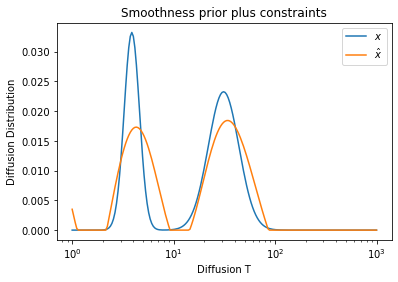

In [30]:
#plot the orignal and estimated signal

plt.figure()
plt.xscale('log')
plt.plot(T,signal, label = "$x$")
plt.plot(T,x_hat, label = "$\hat{x}$")



lines = plt.gca().get_lines()
include = [0,1]
legend1 = plt.legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc=1)

plt.title("Smoothness prior plus constraints")
plt.ylabel('Diffusion Distribution')
plt.xlabel('Diffusion T')
plt.show()

### 3. Sparsity prior

In [31]:
def solver(signal,y, beta):
    #determine nu
    Hess =  K.T@K
    nu = max(np.abs(np.linalg.eigvals(Hess)))
    #initialize x
    x_min = min(signal)
    x_max = max(signal) 
    x = [0.5*(x_min+x_max)]*len(signal)
    x = np.array(x)
    #initialize gamma, delta, lambda
    gamma = 1.99/nu
    delta=2-nu*gamma/2
    lambd = 0.9*delta
    
    #stopping criterions
    max_iter = 6000
    error = 1e6
    
    #initialize number of iteration
    iteration = 1
    while iteration<max_iter and error>1e-8:
        y_n = x - gamma*K.T@(K@x - y)
        #compute prox
        prox = []
        for i in range(len(x)):
            prox.append(np.sign(y_n[i])*max([abs(y_n[i])-gamma*beta,0]))
        prox = np.array(prox)
    
        error = np.linalg.norm(lambd*(prox - x))**2/np.linalg.norm(x)**2
        x = x + lambd*(prox - x)
        iteration+=1
    final_error = (np.linalg.norm(x-signal)/np.linalg.norm(signal))**2 
    return x, final_error

- To choose the optimal $\beta$ that yields the smallest error, we use binary grid with different candidate values for $\beta$. <br>
- When searching for $\beta$ we used small number of iterations (100 iterations), but when estimating the signal with the the optimal $\beta$ value 6000 iterations were needed to converge to the best solution.

In [32]:
#grid of candidate values for beta
betas = [2**i for i in range(-20,0)]

#retrieve the best beta value
best_beta = min(betas, key = lambda c : solver(signal, y, c)[1])

In [33]:
#estimate the signal using the best beta value
x_hat, err = solver(signal, y, best_beta)

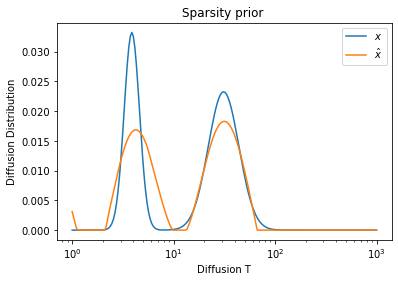

In [34]:
#plot the orignal and estimated signal

plt.figure()
plt.xscale('log')
plt.plot(T,signal, label = "$x$")
plt.plot(T,x_hat, label = "$\hat{x}$")



lines = plt.gca().get_lines()
include = [0,1]
legend1 = plt.legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc=1)

plt.title("Sparsity prior ")
plt.ylabel('Diffusion Distribution')
plt.xlabel('Diffusion T')
plt.show()

We can see the global form of the signal is well reconstructed for smoothness and sparsity prior , but not the special shapes such as the pics. This may be due to the stopping criterion that considers the signal as a whole but not the special forms. Also these priors don't represent well the form of $x$, so we may need other types of priors that offer more flexibility. 

# Second part 

In the theoretical part, we have proven that the equation : 
$$
\hat{x} = \underset{x \in R^{N}}  {\mathrm{argmin}} \; \frac{1}{2} \left\|Kx -y\right\|^{2} + \beta ent(x)
$$
admis a unique minimizer. In order to find this minimizer, we will use two iterative algorithms , **forward-backward** and **Douglas Rachford**.

## Forward-backward algorithm 

In [128]:
def prox_ent_(y_n,gamma,beta) :
    """
    Calculate proximity operator for ent. 
    """
    aux = np.exp((y_n / (gamma * beta)) - 1 - np.log(gamma * beta))
    return gamma * beta * lambertw (aux)
def solver(signal,y, K, beta):
    """
    Find approximate solution of the problem with forward backward algorithm
    """
    #determine nu
    Hess =  K.T@K 
    nu = max(np.abs(np.linalg.eigvals(Hess)))
    #initialize x
    x_min = min(signal)
    x_max = max(signal) 
    x = [0.5*(x_min+x_max)]*len(signal)
    x = np.array(x)
    #initialize gamma, delta, lambda
    gamma = 1.999/nu
    delta=2-nu*gamma/2
    lambd = 0.99*delta
    
    #stopping criterions
    error = 1e6
    
    #initialize number of iteration
    iteration = 1
    max_iter=6000
    
    while iteration<max_iter and error>1e-8:
        grad_g = K.T @ (K@x - y)
        y_n = x - gamma*grad_g
        
        ## Calculate prox operator 
        prox_ent = prox_ent_ (y_n , gamma , beta)
        error = np.linalg.norm(lambd*(prox_ent - x))/np.linalg.norm(x)
        
        x = x + lambd*(prox_ent - x)
        iteration+=1
        
    final_error = (np.linalg.norm(x-signal)/np.linalg.norm(signal))**2
    if math.isnan(final_error) :
        final_error = np.inf
    return x, final_error

In [ ]:
## find best beta
betas = [2**i for i in range(-20,0)]
best_beta = min(betas, key = lambda c : solver(signal, y, K,c)[1])
x_hat, err = solver(signal, y, K,best_beta)

/home/hamza/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


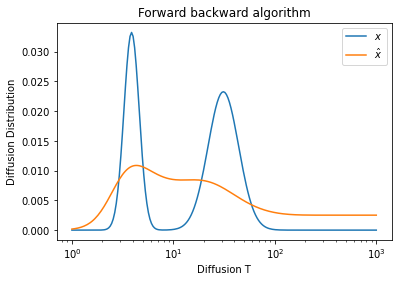

In [130]:
## plot figures

plt.figure()
plt.xscale('log')
plt.plot(T,signal, label = "$x$")
plt.plot(T,x_hat, label = "$\hat{x}$")



lines = plt.gca().get_lines()
include = [0,1]
plt.legend()

plt.title("Forward backward algorithm")
plt.ylabel('Diffusion Distribution')
plt.xlabel('Diffusion T')
plt.show()

## Douglas-Rachford 

In [101]:
import math
def prox_norm(K,v,y,gamma) :
    """
    proximity operator for norm 
    """
    eq1 = np.linalg.inv( gamma * (K.T @ K) + np.eye(K.shape[1]))
    eq2 = (gamma * (K.T @ y))+v
    return eq1 @ eq2 
def solver(signal,y, K, beta):
    #determine nu
    Hess =  K.T@K 
    #initialize x
    x_min = min(signal)
    x_max = max(signal) 
    x = [0.5*(x_min+x_max)]*len(signal)
    x = np.array(x)
    #initialize gamma, lambda
    gamma = 1
    lambd = 1
    
    #stopping criterions
    error = 1e6
    
    #initialize number of iteration
    iteration = 1
    max_iter=10000
    
    while iteration<max_iter and error>1e-8:
        
        y_n = prox_ent_(x,gamma,beta)
        z_n = prox_norm (K,2*y_n-x,y,gamma)
        error = np.linalg.norm(lambd*(z_n - y_n))/np.linalg.norm(x)
        x = x + lambd*(z_n - y_n)
        iteration+=1
    
    final_error = (np.linalg.norm(y_n-signal)/np.linalg.norm(signal))**2
    if math.isnan(final_error) :
        final_error = np.inf
    return y_n, final_error

In [ ]:
betas = [2**i for i in range(-20,0)]
best_beta = min(betas, key = lambda c : solver(signal, y, K,c)[1])
x_hat, err = solver(signal, y, K,best_beta)

/home/hamza/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


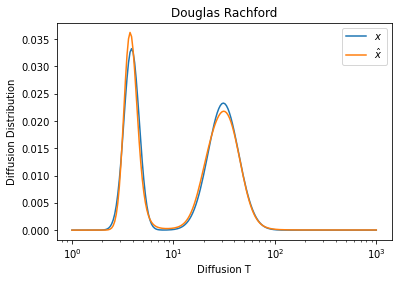

In [103]:
plt.figure()
plt.xscale('log')
plt.plot(T,signal, label = "$x$")
plt.plot(T,x_hat, label = "$\hat{x}$")



lines = plt.gca().get_lines()
include = [0,1]
plt.legend()

plt.title('Douglas Rachford')
plt.ylabel('Diffusion Distribution')
plt.xlabel('Diffusion T')
plt.show()

Meaning a relevant choice for the parameters $\gamma$ and $\lambda$, we can see that Douglas Rachford yields the best results compared to forward-backward and the regularizations of the first part. In fact, this algorithm offers more flexibility since f and g have only to be in $\Gamma_{0}$.


## Question 8 

In order to solve the equation $$ \underset{x \in R^{N}}  {\mathrm{minimize}} \; \; ent(x) \; \; \text{with} \; \left\|Kx -y\right\|^{2} < \eta M \sigma^{2}$$ We can use  PPXA + algorithm that solves the equivalent equation : 
$$ \underset{x \in R^{N}}  {\mathrm{minimize}} \; \; ent(x) + \iota_{C} (Kx) $$ with $C = \mathbb{B}(y,\sigma \sqrt{\eta M}) $

In [155]:
def orth_proj(x,y,c) :
    """
    Calculate the orthognal projection of x on C = B (y,c). 
    """
    aux = x/c-y/c
    s_hat = aux/ max(1, np.linalg.norm(aux)**2)
    x_proj = c * s_hat  + y 
    return x_proj 
    

def solver(signal,y, K, lambd,gamma ,constr):
    
    Hess =  K.T@K 
    nu = max(np.abs(np.linalg.eigvals(Hess)))
    #gamma = 1.999/nu
    #delta=2-nu*gamma/2
    #lambd = 0.99*delta
    
    #initialize x
    x_min = min(signal)
    x_max = max(signal) 
    y_min = min(y)
    y_max = max(y)
    
    x_1 = [0.5*(x_min+x_max)]*len(signal)
    x_1 = np.array(x_1)
    x_2 = [0.5*(y_min+y_max)]*K.shape[0]
    x_2 = np.array(x_2)
    
    # initialize v 
    N = K.shape[1]
    op = np.eye(N) + Hess 
    v_n = np.linalg.inv(op) @ ( x_1 + K.T @ x_2 )  
    
    #stopping criterions
    error = 1e6
    
    #initialize number of iteration
    iteration = 1
    max_iter=10000
    
    while iteration<max_iter and error>1e-8:
        
        y_n_1 = prox_ent_(x_1,gamma,1) 
        y_n_2 = orth_proj(x_2,y,constr)
        c_n = np.linalg.inv(op) @ (y_n_1 + K.T @ y_n_2 )
        c_n = c_n.astype('float64')
        
        x_1 = x_1 + lambd * (2*c_n-v_n - y_n_1)
        x_2 = x_2 + lambd * ( K@(2*c_n-v_n)- y_n_2)
        
        error = np.linalg.norm(lambd*(c_n - v_n))/np.linalg.norm(v_n)
        v_n += lambd *( c_n - v_n)
        iteration+=1
        
    final_error = (np.linalg.norm(v_n-signal)/np.linalg.norm(signal))**2
    return v_n, final_error

In the next cell, we will plot the final error as a function of the parameter $\eta$. The goal of this plot is to see whether th final error varies a lot with respect to $\eta$ as it was the case with $\beta$.  

In [ ]:
from tqdm import tqdm
gamma = 1
beta =1

M = K.shape[0]
sigma = np.sqrt(0.01 * (K@signal)[0])
eta = np.array([2**i for i in range(-20,0)])
constr = sigma  * np.sqrt(eta * M)
tab_err=[]
for c in tqdm(constr, total = len(constr)) : 
    x_hat, err = solver(signal, y, K,gamma,beta,c)
    tab_err.append(err)


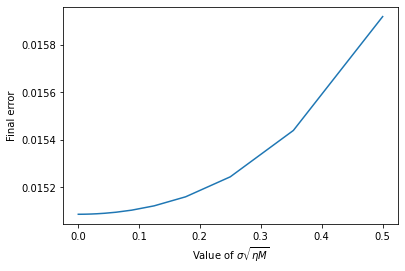

In [117]:
plt.figure()
plt.plot(constr,tab_err)
plt.ylabel('Final error')
plt.xlabel('Value of $\sigma \sqrt{\eta M}$')
plt.show()

We can see that final error varies between 0.0152 and 0.0158 which we may consider as a small range. So this new formulation of the problem is not sensitive to the hyperparameters as it was the case with $\beta$ in the old formulation.

/home/hamza/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:47: ComplexWarning: Casting complex values to real discards the imaginary part


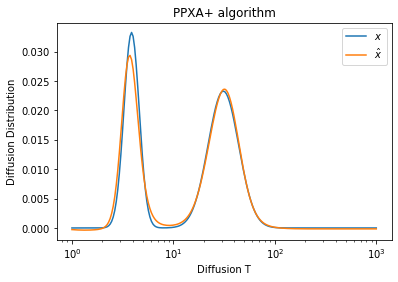

In [119]:
x_hat, err = solver(signal, y, K,1,1,constr[np.argmin(np.array(tab_err))])

plt.figure()
plt.xscale('log')
plt.plot(T,signal, label = "$x$")
plt.plot(T,x_hat, label = "$\hat{x}$")



lines = plt.gca().get_lines()
include = [0,1]
plt.legend()

plt.title("PPXA+ algorithm")
plt.ylabel('Diffusion Distribution')
plt.xlabel('Diffusion T')
plt.show()

## Some remarks and observations about the implementation 

* To approximate the orthogonal projection of $x$ on $C$ , we calculate the orthogonal projection on the unit ball $\hat{s}$ than we have $P_{C}(x) = c \times \hat{s} + y \; with \; c = \sigma \sqrt{\eta M} $.
In fact we can easily show that : 
\begin{equation}
prox_{\iota_{C}}(x) =  \underset{z \in C}  {\mathrm{argmin}} \frac{1}{2} \left\|z-x\right\|^{2} 
                       =\underset{s \in \mathbb{B}(0,1)} {\mathrm{argmin}}  \left\|sc + y -x \right\|^{2} 
\end{equation}

    And then we can find  $\hat{s} = \frac{\frac{x}{c}-\frac{y}{c}}{max(1,\left\|\frac{x}{c}-\frac{y}{c}\right\|^{2} )}$
    
    
* We can see that PPXA+ algorithm gave a good reconstruction of the signal. Therefore this new formulation of the problem, that avoids adjusting $\beta$ is relevant. Nevertheless, it needs a good knowledge of the signal , or some "priors" on its propertiex as it is the case for $\sigma$ and M for our signal.  